In [49]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [50]:
import numpy as np
import pandas as pd

In [51]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [52]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [53]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [54]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [55]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [56]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [57]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [58]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

## Identify table columns in Measurement and Station tables.

In [59]:
Measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [60]:
Station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

## Check last date in Measurement table, calculate 12 months earlier.

In [61]:
session.query(Measurement.date, Measurement.station, Measurement.prcp).order_by(Measurement.date.desc()).first()

('2017-08-23', 'USC00519397', 0.0)

In [62]:
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print((year_ago), type(year_ago))

2016-08-23 <class 'datetime.date'>


## Query Measurement table for data from 2016-08-23 to 2017-08-23 and create dataframe

In [63]:
#To create dataframe, found the pd.read_sql_query(query.statement, engine) from StackOverflow
year_rain = session.query(Measurement.date, Measurement.station, Measurement.prcp).filter(Measurement.date > '2016-08-23')
year_rain_df = pd.read_sql_query(year_rain.statement, engine)
#IMPORTANT: Date and prcp data alone will eliminate station information, but different stations generate different prcp data.
#Cannot remove station data without some link to enable deconvolution of data/prcp data!

## Sort dataframe, index to date, check and replace NaN prcp values, check final dataframe

In [64]:
year_rain_sorted_df = year_rain_df.sort_values('date', ascending=True)
year_rain_sorted2_df = year_rain_sorted_df.set_index('date')
year_rain_sorted3_df = year_rain_sorted2_df.replace(np.nan,0.0)
year_rain_sorted3_df.head()

,station,prcp
date,,
2016-08-24,USC00519397,0.08
2016-08-24,USC00517948,0.00
2016-08-24,USC00519281,2.15
2016-08-24,USC00514830,2.28
2016-08-24,USC00513117,2.15


## Plotting Precipitation Data by Date

Text(0, 0.5, 'Precipitation (Inches)')

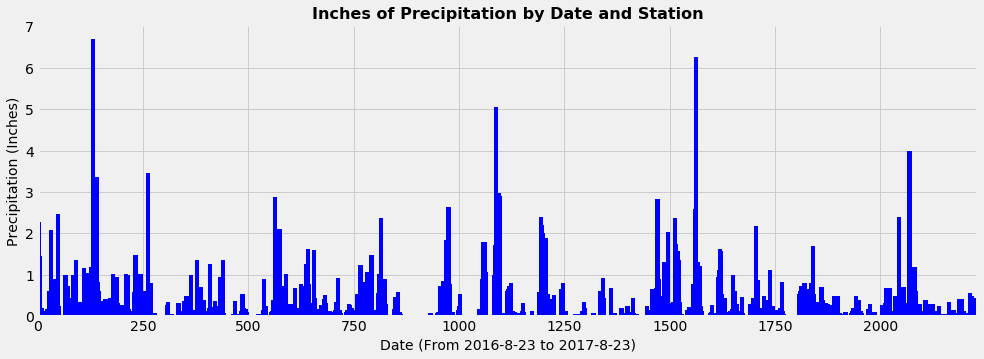

In [65]:
#Matplotlib plotting of prcp data as a bar chart
fig = plt.figure(figsize=(15,5))
x_axis = [i for i in range(len(year_rain_sorted3_df))]

plt.bar(x_axis, height=year_rain_sorted3_df['prcp'], width=10, facecolor='b')
plt.xlim(0,2230)
plt.title('Inches of Precipitation by Date and Station', fontsize=16, fontweight='bold')
plt.xlabel('Date (From 2016-8-23 to 2017-8-23)', fontsize=14)
plt.ylabel('Precipitation (Inches)', fontsize=14)

## Pandas summary statistics for precipitation data

In [66]:
#Pandas summary statistics for the prcp data
year_rain_sorted3_df['prcp'].describe()

count    2223.000000
mean        0.159951
std         0.441220
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000
Name: prcp, dtype: float64

## Number of stations in the dataset using session.query

In [67]:
#station_counts = session.query(Measurement.station).distinct() indicated 9 stations.
#Confining the data to 2016-08-23 indicated 7 stations, agreement with Pandas on filtered data.
#Probably new stations added after 2016-08-23.
station_counts = session.query(Measurement.station).filter(Measurement.date > '2016-08-23').distinct()
station_counts.all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00516128')]

## Check number of stations in Pandas dataframe using df.unique function

In [68]:
year_rain_sorted3_df['station'].unique()

array(['USC00519397', 'USC00517948', 'USC00519281', 'USC00514830',
       'USC00513117', 'USC00516128', 'USC00519523'], dtype=object)

## Most active stations in decending order 

In [69]:
active_stations = year_rain_sorted3_df.groupby(['station'])
active_stations.count().sort_values('prcp', ascending=False)

,prcp
station,
USC00519397,360
USC00519281,351
USC00516128,348
USC00513117,342
USC00519523,336
USC00514830,304
USC00517948,182


## Performed session.query on station USC00519397 and date, constructed dataframe, identified max, min, and mean, plotted histogram. 

In [70]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519397').filter(Measurement.date > '2016-08-23')
active_station_df = pd.read_sql_query(active_station.statement, engine)

In [71]:
(active_station_df['tobs'].max(), active_station_df['tobs'].min(), active_station_df['tobs'].mean())

(87.0, 60.0, 75.19444444444444)

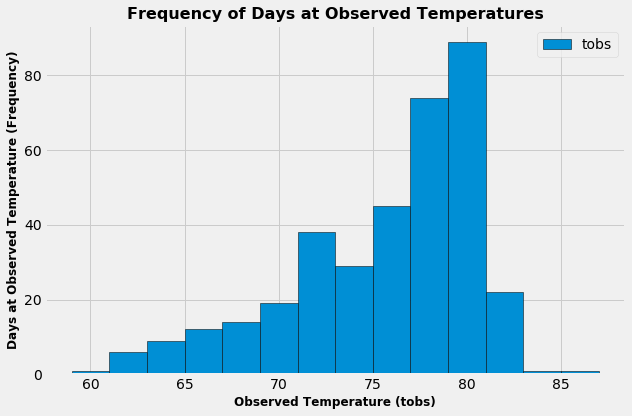

In [72]:
fig = plt.figure(figsize=(9,6))
bins = [59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0]

plt.hist(active_station_df['tobs'], bins=bins, label='tobs', edgecolor='k')
plt.title('Frequency of Days at Observed Temperatures', fontsize=16, fontweight='bold')
plt.xlabel('Observed Temperature (tobs)', fontsize=12, fontweight='bold')
plt.ylabel('Days at Observed Temperature (Frequency)', fontsize=12, fontweight='bold')
plt.legend(loc='upper right')
plt.tight_layout()

In [73]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [74]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2016-07-01', '2016-07-15')
trip_temp

[(71.0, 77.06382978723404, 82.0)]

In [75]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [76]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Alternative Approach:Read Measurement and Station tables directly into Pandas for analysis.

In [77]:
#Alternative method: use pd.read_sql to generate dataframe from database tables.
measure = pd.read_sql("SELECT * FROM Measurement", engine)
measure.head(3)
#The following gives the start date and the final end date of the data as a tuple.
#(measure.head(2), measure.tail(2))

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0


In [78]:
#Alternative method: use pd.read_sql to generate dataframe from database tables.
station = pd.read_sql("SELECT * FROM Station", engine)
station.head(3)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0


## Optional Challenge Assignment

In [79]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [80]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [81]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [82]:
# Plot the daily normals as an area plot with `stacked=False`
